# Reproducing EMNLP 2024 Paper: Multi-Target Cross-Lingual Summarization

Using SONAR encoder from Meta's Hugging Face repo via `sonar-space`.

In [60]:
# ✅ Install dependencies
!pip install -q transformers datasets evaluate rouge-score sentence-transformers
!pip install sonar-space
!pip install fairseq2 --extra-index-url https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
!pip install comet_ml
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://fair.pkg.atmeta.com/fairseq2/whl/pt2.6.0/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


## 🔍 Load SONAR Encoder and Compute Similarity

In [3]:
from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize SONAR embedding model
sonar_model = TextToEmbeddingModelPipeline(
    encoder="text_sonar_basic_encoder",
    tokenizer="text_sonar_basic_encoder",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

def similarity_score(text1, text2):
    emb = sonar_model.predict([text1, text2], source_lang="eng_Latn")
    return float(cosine_similarity([emb[0].cpu().numpy()], [emb[1].cpu().numpy()])[0][0])


100%|██████████| 2.85G/2.85G [00:23<00:00, 128MB/s]
100%|██████████| 4.63M/4.63M [00:00<00:00, 142MB/s]


## ✨ Example: Re-Rank Candidate Summaries Based on Semantic Coherence

In [4]:
# Placeholder: Example candidate summaries for demonstration
candidates = {
    'es': ['Bitcoin consume más energía que Argentina.', 'Bitcoin es muy costoso en electricidad.'],
    'fr': ['Le Bitcoin consomme plus que l’Argentine.', 'Bitcoin a un coût énergétique élevé.']
}

# Re-rank using similarity
from itertools import product

def neutral_rr(candidates):
    best_set = None
    best_score = -1
    for combo in product(*candidates.values()):
        score = 0
        for i in range(len(combo)):
            for j in range(i+1, len(combo)):
                score += similarity_score(combo[i], combo[j])
        avg_score = score / (len(combo)*(len(combo)-1)/2)
        if avg_score > best_score:
            best_score = avg_score
            best_set = combo
    return best_set, best_score

best_summaries, score = neutral_rr(candidates)
print('Best Semantically Coherent Summaries:')
for lang, summ in zip(candidates.keys(), best_summaries):
    print(f'{lang}: {summ}')
print(f'Average Pairwise Similarity: {score:.4f}')


Best Semantically Coherent Summaries:
es: Bitcoin consume más energía que Argentina.
fr: Le Bitcoin consomme plus que l’Argentine.
Average Pairwise Similarity: 0.7359


## 🧠 Generate Summaries with mT5 (English → Multilingual)

In [27]:
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load mT5 fine-tuned on CrossSum
model_name = "csebuetnlp/mT5_m2m_crossSum"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

article_text = """Videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down, the company said.  The policy includes the termination of accounts of anti-vaccine influencers.  Tech giants have been criticised for not doing more to counter false health information on their sites.  In July, US President Joe Biden said social media platforms were largely responsible for people's scepticism in getting vaccinated by spreading misinformation, and appealed for them to address the issue.  YouTube, which is owned by Google, said 130,000 videos were removed from its platform since last year, when it implemented a ban on content spreading misinformation about Covid vaccines.  In a blog post, the company said it had seen false claims about Covid jabs "spill over into misinformation about vaccines in general". The new policy covers long-approved vaccines, such as those against measles or hepatitis B.  "We're expanding our medical misinformation policies on YouTube with new guidelines on currently administered vaccines that are approved and confirmed to be safe and effective by local health authorities and the WHO," the post said, referring to the World Health Organization."""

get_lang_id = lambda lang: tokenizer._convert_token_to_id(
    model.config.task_specific_params["langid_map"][lang][1]
)

def generate_summary(text, target_lang):
    input_ids = tokenizer(
        [WHITESPACE_HANDLER(text)],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        decoder_start_token_id=get_lang_id(target_lang),
        max_length=84,
        no_repeat_ngram_size=2,
        num_beams=4,
    )[0]

    return tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )


In [30]:
# Example English news article
text = (
    "Bitcoin uses more electricity annually than the whole of Argentina, "
    "analysis by Cambridge University suggests. Mining for the cryptocurrency "
    "is power-hungry, involving heavy computer calculations to verify transactions."
)

langs = {
    "fr": "french",
    "es": "spanish",
    "pt": "portuguese",
    "pu": "punjabi",
    "ko": "korean"
}

for code, full_lang in langs.items():
    summary = generate_summary(text, target_lang=full_lang)
    print(f"{full_lang} summary: {summary}")


french summary: Le Bitcoin est l'un des plus grands bancaires du monde, selon une étude.
spanish summary: El bitcoin es la criptomoneda más grande del mundo, según un nuevo estudio.
portuguese summary: A criptomoeda Bitcoin é a moeda mais valiosa do mundo, segundo um estudo da Universidade de Cambridge, na Grã-Bretanha.
punjabi summary: ਇੱਕ ਅਧਿਐਨ ਮੁਤਾਬਕ ਦੁਨੀਆਂ ਦੇ ਸਭ ਤੋਂ ਵੱਡੇ ਟਵਿੱਟਰ ਬੈਂਕ ਦੀ ਵਰਤੋਂ ਕਰਨ ਵਾਲੇ ਯੂਕੇ ਦੇ ਕਰੀਬ ਤਿੰਨ ਗੁਣਾ ਹੋ ਗਏ ਹਨ।
korean summary: '비트코인 채굴'는 세계에서 가장 큰 규모의 신종 코로나바이러스 감염증(코로나19) 팬데믹이 됐다.


## 📚 Load and Cluster CrossSum Dataset for Multi-Target Summarization

In [128]:
from datasets import load_dataset
from collections import defaultdict

# Load CrossSum dataset
def load_and_preview_crosssum(split_name="english-french", num_samples=5):
    crosssum = load_dataset("csebuetnlp/CrossSum", split_name)

    print(f"\n✅ Loaded CrossSum split: {split_name}")
    print(f"Available splits: {list(crosssum.keys())}")

    # Preview samples from the 'test' set
    for i in range(min(num_samples, len(crosssum["test"]))):
        sample = crosssum["test"][i]
        print(f"\nSample {i+1}")
        print("📰 Source (English):", sample["text"][:150], "...")
        print("📝 Reference Summary (Target language):", sample["summary"][:150], "...")

    return crosssum


## 🚀 Apply mT5 and SONAR Reranking on a CrossSum Cluster

In [162]:
crosssum_french = load_and_preview_crosssum("english-french", num_samples=1)
source_sample_french = crosssum_french["test"][3]
source_text_french = source_sample_french["text"]

crosssum_english = load_and_preview_crosssum("english-english", num_samples=1)
source_sample_english = crosssum_english["test"][4]
source_text_english = source_sample_english["text"]

# Load and preview the English-Spanish split, then extract the first article
crosssum_spanish = load_and_preview_crosssum("english-spanish", num_samples=1)
source_sample_spanish = crosssum_spanish["test"][0]
source_text_spanish = source_sample_spanish["text"]

# Compare source documents
print("\n📰 Source Document (English → English):\n", source_text_english[:300], "...\n")
print("📰 Source Document (English → Spanish):\n", source_text_spanish[:300], "...\n")
print("📰 Source Document (English → French):\n", source_text_french[:300], "...\n")


✅ Loaded CrossSum split: english-french
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): By Geeta PandeyBBC News, Delhi Earlier this month, a video clip went viral in India. It showed a group of men, with orange scarves draped around their ...
📝 Reference Summary (Target language): Des informations selon lesquelles une femme hindoue enceinte qui a été séparée de force de son mari musulman et qui a peut-être ensuite fait une fauss ...

✅ Loaded CrossSum split: english-english
Available splits: ['train', 'test', 'validation']

Sample 1
📰 Source (English): The bus overturned and was sent hurtling down the road for about 25 metres. The local hospital says fifteen children were among those killed. The gove ...
📝 Reference Summary (Target language): The attack happened in the early morning when the bus was packed with villagers travelling to work and school. It was hit by a mine explosion. ...

✅ Loaded CrossSum split: english-spanish
Available splits: ['train

In [163]:
# Generate Spanish summary and use Spanish reference
spanish_reference = source_sample_spanish["summary"]
spanish_generated = generate_summary(source_text_spanish, target_lang="spanish")

candidates_spanish = {
    "reference": [spanish_reference],
    "generated": [spanish_generated]
}

# Generate French summary and use French reference
french_reference = source_sample_french["summary"]
french_generated = generate_summary(source_text_french, target_lang="french")

candidates_french = {
    "reference": [french_reference],
    "generated": [french_generated]
}


# Generate english summary and use english reference
english_reference = source_sample_english["summary"]
english_generated = generate_summary(source_text_english, target_lang="english")

candidates_english = {
    "reference": [english_reference],
    "generated": [english_generated]
}

# Apply NeutralRR to Korean summaries
best_english_summaries, english_score = neutral_rr(candidates_english)
print("\n English NeutralRR Result:")
for lang, summ in zip(candidates_english.keys(), best_english_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (english): {english_score:.4f}")

# Apply NeutralRR to Spanish summaries
best_spanish_summaries, spanish_score = neutral_rr(candidates_spanish)
print("\n Spanish NeutralRR Result:")
for lang, summ in zip(candidates_spanish.keys(), best_spanish_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (Spanish): {spanish_score:.4f}")

# Apply NeutralRR to French summaries
best_french_summaries, french_score = neutral_rr(candidates_french)
print("\n French NeutralRR Result:")
for lang, summ in zip(candidates_french.keys(), best_french_summaries):
    print(f"{lang.capitalize()}: {summ}")
print(f"Average Similarity (French): {french_score:.4f}")







 English NeutralRR Result:
Reference: Dozens of elephants and rafts have been deployed to rescue nearly 500 people trapped by floods in a popular resort in southern Nepal, officials say.
Generated: A number of elephants have been used to carry out rescue efforts in Nepal, officials say.
Average Similarity (english): 0.5037

 Spanish NeutralRR Result:
Reference: El fundador de WikiLeaks, Julian Assange, fue arrestado este jueves por la mañana por la policía británica en la embajada de Ecuador en Londres.
Generated: El fundador de WikiLeaks, Julian Assange, fue detenido este viernes en el consulado de su país en Londres.
Average Similarity (Spanish): 0.7279

 French NeutralRR Result:
Reference: Le rappeur américain, Kanye West, a été transporté d'urgence à l'hôpital.
Generated: Le rappeur américain Kanye West a été hospitalisé à l'hôpital de Los Angeles après qu'il était en quarantaine.
Average Similarity (French): 0.6242


## 📏 Evaluate with ROUGE and Export Results

In [164]:
from rouge_score import rouge_scorer
import pandas as pd

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)

# Get references
reference_summary_fr = source_sample_french["summary"]
reference_summary_es = source_sample_spanish["summary"]
reference_summary_en = source_sample_english["summary"]

# Prepare output
records = []

# -- Evaluate French generated summary --
for lang, summary in zip(candidates_french.keys(), best_french_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_fr, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "french",
            "generated_summary": summary,
            "reference_summary": reference_summary_fr,
            "rouge2_f1": round(rouge_f1, 4)
        })

# -- Evaluate Spanish generated summary --
for lang, summary in zip(candidates_spanish.keys(), best_spanish_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_es, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "spanish",
            "generated_summary": summary,
            "reference_summary": reference_summary_es,
            "rouge2_f1": round(rouge_f1, 4)
        })

# -- Evaluate English generated summary --
for lang, summary in zip(candidates_english.keys(), best_english_summaries):
    if lang == "generated":
        score = scorer.score(reference_summary_en, summary)
        rouge_f1 = score["rouge2"].fmeasure
        records.append({
            "language": "english",
            "generated_summary": summary,
            "reference_summary": reference_summary_en,
            "rouge2_f1": round(rouge_f1, 4)
        })

# Display results
df = pd.DataFrame(records)
df



,language,generated_summary,reference_summary,rouge2_f1
0,french,Le rappeur américain Kanye West a été hospital...,"Le rappeur américain, Kanye West, a été transp...",0.5294
1,spanish,"El fundador de WikiLeaks, Julian Assange, fue ...","El fundador de WikiLeaks, Julian Assange, fue ...",0.3182
2,english,A number of elephants have been used to carry ...,Dozens of elephants and rafts have been deploy...,0.2051


In [165]:
# Export results to CSV
output_path = "/content/neutralrr_results.csv"
df.to_csv(output_path, index=False)
print(f"📁 Results exported to: {output_path}")


📁 Results exported to: /content/neutralrr_results.csv


## 🧪 Evaluate with BLEU Score

In [166]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to compute BLEU score
def compute_bleu(reference, prediction):
    smoothie = SmoothingFunction().method4
    reference_tokens = [reference.split()]
    prediction_tokens = prediction.split()
    return sentence_bleu(reference_tokens, prediction_tokens, smoothing_function=smoothie)

# Add BLEU to DataFrame (only if reference is real, not placeholder)
df["bleu"] = df.apply(
    lambda row: round(compute_bleu(row["reference_summary"], row["generated_summary"]), 4)
    if isinstance(row["reference_summary"], str) and row["reference_summary"] != "N/A"
    else "N/A",
    axis=1
)

# Display final scores
df[["language", "rouge2_f1", "bleu"]]


,language,rouge2_f1,bleu
0,french,0.5294,0.0511
1,spanish,0.3182,0.2787
2,english,0.2051,0.0719


In [167]:
# Re-export with BLEU
output_path_bleu = "/content/neutralrr_results_bleu.csv"
df.to_csv(output_path_bleu, index=False)
print(f"📁 Results with BLEU exported to: {output_path_bleu}")


📁 Results with BLEU exported to: /content/neutralrr_results_bleu.csv


## 📊 Visualize ROUGE and BLEU Scores

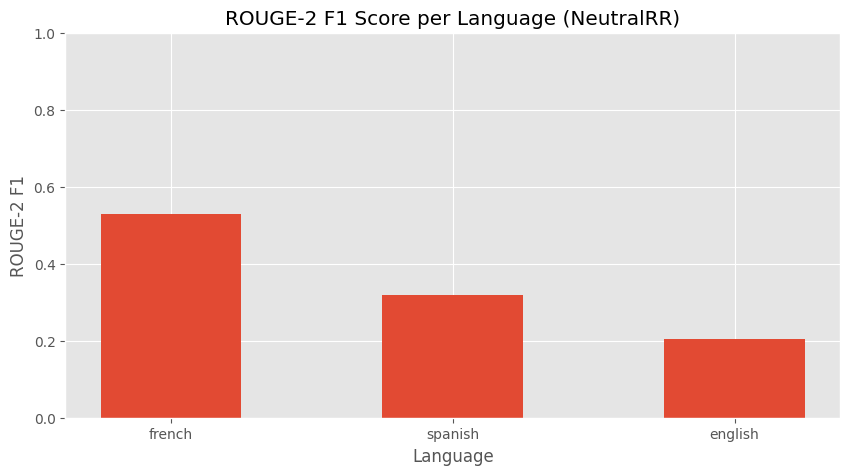

In [168]:
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use("ggplot")

# Bar chart for ROUGE-2 F1
plt.figure(figsize=(10, 5))
plt.bar(df["language"], df["rouge2_f1"], width=0.5)
plt.title("ROUGE-2 F1 Score per Language (NeutralRR)")
plt.ylabel("ROUGE-2 F1")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.show()


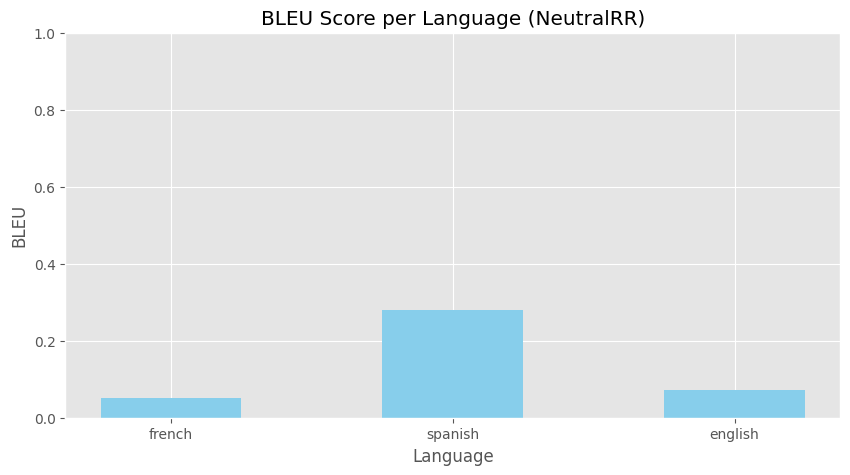

In [169]:
# Bar chart for BLEU Score
plt.figure(figsize=(10, 5))
plt.bar(df["language"], df["bleu"], width=0.5, color='skyblue')
plt.title("BLEU Score per Language (NeutralRR)")
plt.ylabel("BLEU")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.show()
